## Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [20]:
pd.set_option('display.max_columns', None)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

## Read

In [22]:
# Read cleaned data

df = pd.read_csv('data/cleaned_credit_data.csv')
print(df.shape)
df.head()

(6015, 14)


,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Credit_Score
0,28,34847,2,4,0.06,1,3,4,2,Good,605,0.33,326,Good
1,34,143162,1,5,0.08,3,8,6,3,Good,1303,0.38,220,Standard
2,34,131313,0,1,0.08,2,0,2,4,Good,352,0.29,374,Good
3,24,114838,2,5,0.07,3,11,11,8,Good,1377,0.28,263,Standard
4,36,54392,6,4,0.14,3,10,8,7,Standard,179,0.33,329,Standard


## Dummy Coding

In [23]:
# One Hot Encoder - Creating Dummy Variables for 'Credit_Mix

ohe = preprocessing.OneHotEncoder(sparse=False)

oh_encoded = ohe.fit_transform(df[['Credit_Mix']])
df_oh_encoded = pd.DataFrame(oh_encoded, columns=ohe.get_feature_names_out(['Credit_Mix']))

df = pd.concat([df, df_oh_encoded], axis=1)

df.drop(['Credit_Mix'], axis=1, inplace=True)

df.head()


/Users/davidekim/tensorflow/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Credit_Score,Credit_Mix_Bad,Credit_Mix_Good,Credit_Mix_Standard
0,28,34847,2,4,0.06,1,3,4,2,605,0.33,326,Good,0.0,1.0,0.0
1,34,143162,1,5,0.08,3,8,6,3,1303,0.38,220,Standard,0.0,1.0,0.0
2,34,131313,0,1,0.08,2,0,2,4,352,0.29,374,Good,0.0,1.0,0.0
3,24,114838,2,5,0.07,3,11,11,8,1377,0.28,263,Standard,0.0,1.0,0.0
4,36,54392,6,4,0.14,3,10,8,7,179,0.33,329,Standard,0.0,0.0,1.0


## Split Data (Test & Train)

In [24]:
# Separate X from y

outcome = 'Credit_Score'
predictors = list(df.columns)
predictors.remove(outcome)

X = df[predictors]
y = df[outcome]

In [25]:
# split dataset into training (70%) and test (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4210, 15) (1805, 15) (4210,) (1805,)


## Label Encoding for y

In [27]:
# 0 - Good, 1 - Poor, 2 - Standard

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

## Scaling

In [29]:
# Standardize

scaler = preprocessing.StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## K-NN Classfication Model

In [30]:
# Try out K-NN model with k=1

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.4886426592797784


In [31]:
# Let's find the best number for k

results = []
for k in range(1, 100, 2):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_scaled, y_train)
    
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_test, knn.predict(X_test_scaled))
    })

results_df = pd.DataFrame(results)
results_df.loc[results_df.accuracy == results_df.accuracy.max()]

,k,accuracy
41,83,0.600554


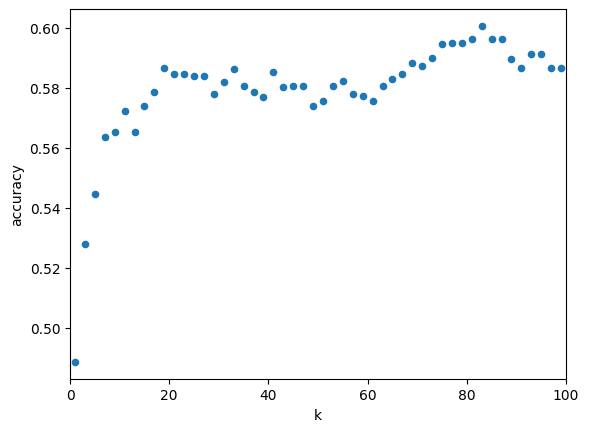

In [32]:
results_df.plot.scatter(x='k', y='accuracy', xlim=[0, 100]);

In [33]:
# We choose k=83 based on the accuracy
# Confusion Matrix

knn = KNeighborsClassifier(n_neighbors=83)
knn.fit(X_train_scaled, y_train)

pred_y = knn.predict(X_test_scaled)
print(confusion_matrix(y_test, pred_y))
print('Accuracy:', accuracy_score(y_test, pred_y))

[[194  10 157]
 [ 49 258 207]
 [150 148 632]]
Accuracy: 0.6005540166204986


## Data Reduction

In [34]:
# Let's find out the ideal number of components first

pcs = PCA()
pcs.fit(X_train_scaled)

# view the importance of principal components
pcsSummary_df = pd.DataFrame({
            'Proportion of variance': pcs.explained_variance_ratio_,
            'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)
            })
pcsSummary_df.round(3)

,Proportion of variance,Cumulative proportion
0,0.439,0.439
1,0.123,0.562
2,0.072,0.634
3,0.064,0.698
4,0.050,0.748
5,0.046,0.794
6,0.040,0.834
7,0.031,0.865
8,0.027,0.892
9,0.027,0.918


     0     1     2     3     4     5    6     7     8    9     10    11    12  \
0  6.59  1.85  1.08  0.96  0.75  0.68  0.6  0.46  0.41  0.4  0.38  0.38  0.29   

     13   14  
0  0.18  0.0  


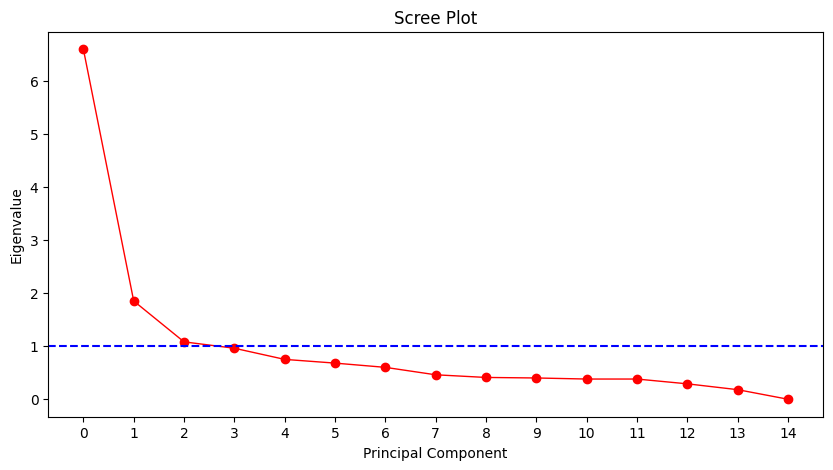

In [35]:
# Latent Root Criterion (Kaiser) and Scree Test

eig=pcs.explained_variance_.round(2)
print(pd.DataFrame(eig).T)

xvals = np.arange(X_train_scaled.shape[1]);

plt.figure(figsize=(10,5))
plt.plot(xvals, eig, 'ro-', linewidth=1)
plt.xticks(xvals)

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

plt.axhline(y=1, color='b', linestyle='--')

1. Percentage of Variance Criterion: First 5

2. Latent Root Criterion / Kaiser Rule: First 3

3. Scree Test Criterion: First 2

In [36]:
# 1. Percentage of Variance Criterion: First 5

pcs = PCA(n_components=5)
X_train_pcs = pcs.fit_transform(X_train_scaled)
X_test_pcs = pcs.transform(X_test_scaled)

results = []
for k in range(1, 200, 2):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_pcs, y_train)
    
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_test, knn.predict(X_test_pcs))
    })

results_df = pd.DataFrame(results)
results_df.loc[results_df.accuracy == results_df.accuracy.max()]

,k,accuracy
99,199,0.581163


In [37]:
# 2. Latent Root Criterion / Kaiser Rule: First 3

pcs = PCA(n_components=3)
X_train_pcs = pcs.fit_transform(X_train_scaled)
X_test_pcs = pcs.transform(X_test_scaled)

results = []
for k in range(1, 100, 2):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_pcs, y_train)
    
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_test, knn.predict(X_test_pcs))
    })

results_df = pd.DataFrame(results)
results_df.loc[results_df.accuracy == results_df.accuracy.max()]

,k,accuracy
29,59,0.585042


In [38]:
# 3. Scree Test Criterion: First 2

pcs = PCA(n_components=1)
X_train_pcs = pcs.fit_transform(X_train_scaled)
X_test_pcs = pcs.transform(X_test_scaled)

results = []
for k in range(1, 200, 2):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_pcs, y_train)
    
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_test, knn.predict(X_test_pcs))
    })

results_df = pd.DataFrame(results)
results_df.loc[results_df.accuracy == results_df.accuracy.max()]

,k,accuracy
74,149,0.58338
85,171,0.58338
